## Imports

In [1]:
import pandas as pd
import numpy as np
import pypsa
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import plotly
import datetime
import seaborn as sns
import ast

from utils import market_values, market_values_by_time_index

In [2]:
n =pypsa.Network("../data/raw/elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc")

Importing PyPSA from older version of PyPSA than current version.
Please read the release notes at https://pypsa.readthedocs.io/en/latest/release_notes.html
carefully to prepare your network for import.
Currently used PyPSA version [0, 20, 1], imported network file PyPSA version [0, 18, 1].

INFO:pypsa.io:Imported network elec_s_181_lv1.0__Co2L0-3H-T-H-B-I-A-solar+p3-linemaxext10-noH2network_2030.nc has buses, carriers, generators, global_constraints, lines, links, loads, storage_units, stores


In [3]:
n.storage_units_t.p

StorageUnit,AT0 0 hydro,AT0 1 PHS,AT0 1 hydro,AT0 2 PHS,AT0 2 hydro,BE0 1 PHS,BE0 1 hydro,BG0 0 hydro,BG0 1 PHS,BG0 1 hydro,...,SE3 3 hydro,SE3 4 hydro,SE3 5 hydro,SE3 6 PHS,SE3 6 hydro,SE3 7 hydro,SI0 0 PHS,SI0 0 hydro,SK0 0 PHS,SK0 0 hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.012865,0.041039,0.003039,-0.009721,0.009953,-0.036106,0.013979,319.190476,72.512364,1165.298713,...,0.003265,0.015847,0.019115,0.043090,288.543736,0.016225,59.590499,730.785534,0.003466,98.603409
2013-01-01 03:00:00,0.012841,0.024226,0.002972,-0.010176,0.009789,-0.011099,0.024839,319.190472,1159.076994,1165.298695,...,0.003257,0.010948,0.012895,0.065493,288.689276,0.011146,40.199534,730.785526,0.015739,94.322064
2013-01-01 06:00:00,0.008043,0.015460,0.002940,-0.040535,0.007463,-0.027069,0.021429,319.189436,0.026051,1165.298007,...,0.004014,0.014472,0.017224,0.064525,288.715495,0.014713,0.001124,730.783770,0.011896,0.054735
2013-01-01 09:00:00,0.002082,-542.779577,0.002591,-1829.290856,0.002801,-0.078550,0.015965,0.014910,-1398.984653,0.018543,...,0.008538,0.015898,0.016398,-91.977821,0.011502,0.016099,-184.992470,0.025293,-1021.272174,0.002086
2013-01-01 12:00:00,0.006093,-0.093714,0.002674,-32.098796,0.006246,-0.184040,0.015972,319.189435,0.045875,1165.298061,...,29.786837,204.697089,176.195500,0.012741,55.011600,197.137294,-0.008166,730.783337,-0.053098,0.010078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.006801,-2411.990162,0.001668,-0.008033,0.010581,-1163.908127,0.005519,319.189913,0.038533,1165.298066,...,0.006355,0.024361,0.016715,-0.099673,0.053854,0.022366,0.030740,730.785091,-0.094936,78.185793
2013-12-31 12:00:00,0.006966,-1169.808270,0.002522,-0.009887,0.010383,-0.064200,0.008708,319.189958,0.041612,1165.298126,...,0.007661,0.022220,0.023819,-0.162239,0.052338,0.022571,0.007974,730.784440,-0.041091,789.270206
2013-12-31 15:00:00,0.007940,0.258793,0.003204,-0.001086,0.012742,-0.088930,0.008626,319.190484,739.465403,1165.298713,...,0.007500,0.022204,0.023620,-0.098356,0.051981,0.022462,0.267197,730.785448,-0.007880,791.920057


In [4]:
# overall generation: active power at bus (positive if net generation at bus) in MW
n.buses_t.p

Bus,AL0 0,AL0 0 EV battery,AL0 0 H2,AL0 0 H2 liquid,AL0 0 battery,AL0 0 home battery,AL0 0 low voltage,AL0 0 residential rural heat,AL0 0 residential rural water tanks,AL0 0 residential urban decentral heat,...,SK0 0 services rural water tanks,SK0 0 services urban decentral heat,SK0 0 services urban decentral water tanks,SK0 0 urban central heat,SK0 0 urban central water tanks,co2 atmosphere,co2 stored,gas for industry,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-608.163407,-9.079289e-08,2.133122e-06,4.495180e-07,1.635940e-06,-9.534975e-07,-5.313130e-08,0.000006,-1.489416e-08,-0.000008,...,-7.055290e-09,0.000048,-8.912204e-09,0.000069,-1.881899e-08,-4.887948e-07,0.000003,-3.744317e-07,-3.287678e-07,1.735170e-07
2013-01-01 03:00:00,-581.055247,-3.748977e-07,1.160617e-06,4.495180e-07,4.570022e-07,-1.197959e-06,-6.548025e-07,-0.000039,-8.509398e-09,-0.000025,...,-1.044024e-08,-0.000060,-9.961686e-09,-0.000086,7.794030e-09,8.283217e-08,0.000003,-3.744317e-07,-3.287678e-07,1.735170e-07
2013-01-01 06:00:00,1754.697653,1.512844e-07,-8.014138e-07,4.495180e-07,-2.234797e-04,6.834004e-08,6.329118e-08,0.000019,-9.922386e-09,-0.000016,...,-8.740590e-09,-0.000041,-8.521342e-09,-0.000059,1.400640e-08,-4.886566e-07,0.000003,-3.744317e-07,-3.287678e-07,1.735170e-07
2013-01-01 09:00:00,2405.927337,-4.500230e-07,-1.237522e-06,4.495180e-07,-4.573655e-04,-5.502602e-07,1.322039e-07,-0.000004,-9.791693e-09,-0.000016,...,-6.147678e-09,0.000031,-8.773595e-09,0.000043,-1.388392e-08,-4.888938e-07,0.000003,-3.744317e-07,-3.287678e-07,1.735170e-07
2013-01-01 12:00:00,1066.208332,2.821321e-07,3.324496e-07,4.495180e-07,-4.594787e-04,4.810797e-07,5.638632e-08,-0.000024,-2.027343e-09,-0.000011,...,-1.010557e-08,-0.000077,-8.167377e-09,-0.000108,4.557956e-09,-4.885105e-07,0.000003,-3.744317e-07,-3.287678e-07,1.735170e-07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,408.769997,1.247315e-09,-4.095881e-07,4.495180e-07,-4.541463e-04,-3.169613e-08,-1.714413e-07,0.000028,-1.421219e-08,-0.000011,...,-1.249301e-08,-0.000019,-1.077348e-08,-0.000026,-2.521626e-08,-4.889882e-07,-0.000045,-3.744317e-07,-3.287678e-07,1.735170e-07
2013-12-31 12:00:00,151.545199,-3.360129e-07,2.329806e-07,4.495180e-07,-2.595504e-04,-2.222809e-07,-4.818554e-08,-0.000017,-1.069220e-08,0.000005,...,-1.170578e-08,0.000052,-1.001687e-08,0.000074,-4.497013e-08,-4.888327e-07,-0.000041,-3.744317e-07,-3.287678e-07,1.735170e-07
2013-12-31 15:00:00,3009.872193,9.805703e-08,-1.437836e-06,4.495180e-07,-3.357515e-06,-3.122251e-07,-3.109597e-07,0.000012,-3.233202e-09,-0.000008,...,-6.176270e-09,-0.000065,-1.008166e-08,-0.000093,1.273984e-08,-4.888315e-07,-0.000036,-3.744317e-07,-3.287678e-07,1.735170e-07


In [5]:
n.generators_t.p_max_pu

Generator,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 residential rural solar thermal collector,AL0 0 residential urban decentral solar thermal collector,AL0 0 services rural solar thermal collector,AL0 0 services urban decentral solar thermal collector,AL0 0 solar,AL0 0 solar rooftop,AL0 0 urban central solar thermal collector,AT0 0 onwind,...,SI0 0 urban central solar thermal collector,SK0 0 onwind,SK0 0 residential rural solar thermal collector,SK0 0 residential urban decentral solar thermal collector,SK0 0 ror,SK0 0 services rural solar thermal collector,SK0 0 services urban decentral solar thermal collector,SK0 0 solar,SK0 0 solar rooftop,SK0 0 urban central solar thermal collector
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.212092,...,0.000000,0.370957,0.000000,0.000000,0.106059,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.199429,...,0.000000,0.410429,0.000000,0.000000,0.106347,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.212342,0.212342,0.000000,0.149067,...,0.000000,0.425850,0.000000,0.000000,0.106370,0.000000,0.000000,0.096427,0.096427,0.000000
2013-01-01 09:00:00,0.000000,0.000000,0.258074,0.258074,0.258074,0.258074,0.509680,0.509680,0.258074,0.063472,...,0.158844,0.311015,0.035745,0.035745,0.106495,0.035745,0.035745,0.342504,0.342504,0.035745
2013-01-01 12:00:00,0.000000,0.000000,0.252337,0.252337,0.252337,0.252337,0.282403,0.282403,0.252337,0.021450,...,0.188041,0.225632,0.084352,0.084352,0.106541,0.084352,0.084352,0.161330,0.161330,0.084352
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000000,0.000000,0.020393,0.020393,0.020393,0.020393,0.217482,0.217482,0.020393,0.019345,...,0.000000,0.011574,0.000000,0.000000,0.158794,0.000000,0.000000,0.163296,0.163296,0.000000
2013-12-31 12:00:00,0.000000,0.000000,0.016879,0.016879,0.016879,0.016879,0.132394,0.132394,0.016879,0.055680,...,0.010854,0.031714,0.000000,0.000000,0.157693,0.000000,0.000000,0.100254,0.100254,0.000000
2013-12-31 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083365,...,0.000000,0.076537,0.000000,0.000000,0.157553,0.000000,0.000000,0.000000,0.000000,0.000000


In [6]:
lmp_regions = n.buses_t.marginal_price.loc[:, n.buses.location.unique()[:-1]]
lmp_regions.columns

Index(['AL0 0', 'AT0 0', 'AT0 1', 'AT0 2', 'BA0 0', 'BE0 0', 'BE0 1', 'BE0 2',
       'BE0 3', 'BE0 4',
       ...
       'SE3 0', 'SE3 1', 'SE3 2', 'SE3 3', 'SE3 4', 'SE3 5', 'SE3 6', 'SE3 7',
       'SI0 0', 'SK0 0'],
      dtype='object', name='Bus', length=181)

## Price Duration curve

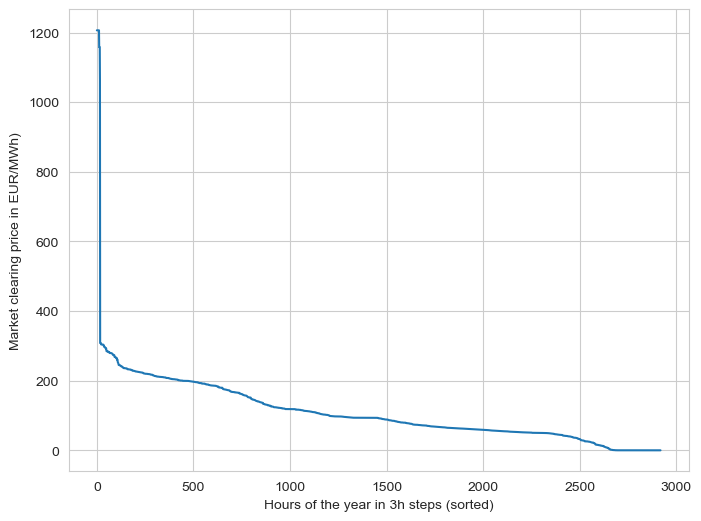

In [7]:
# price duration curve per region
plt.figure(figsize=(8, 6))
plt.plot(lmp_regions['SK0 0'].sort_values(ascending=False).values)
# plt.ylim(-100, 500)
plt.xlabel("Hours of the year in 3h steps (sorted)")
plt.ylabel("Market clearing price in EUR/MWh)")
plt.show()

# would be interesting to see which technology is the price setter in the respecting hour
# calculating area under the curve to see how much investment is in the market?

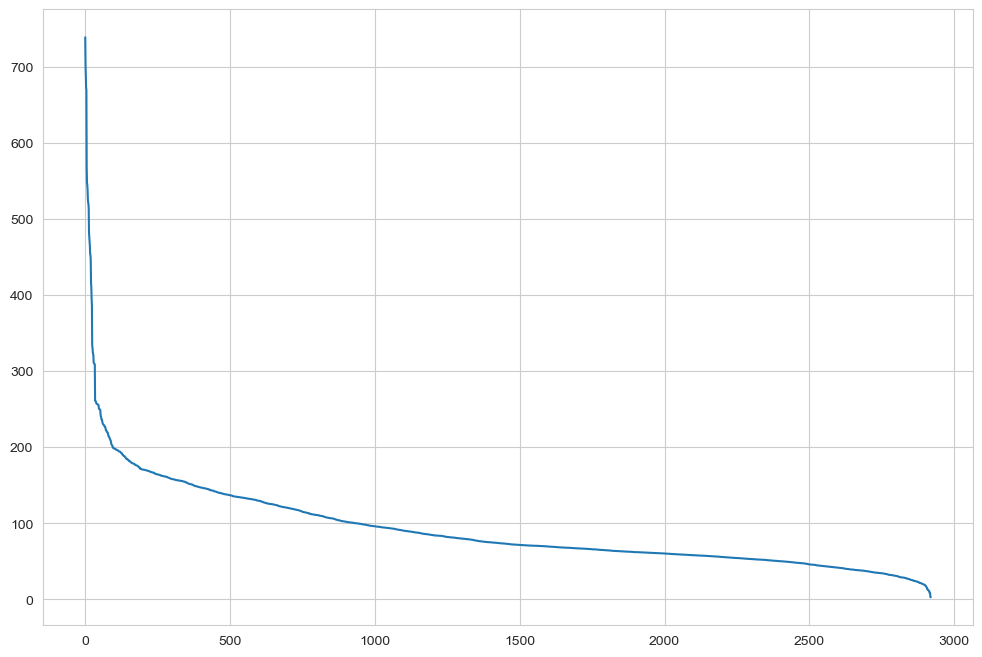

In [8]:
# overall price duration curve (mean aggregation)
plt.figure(figsize=(12, 8))
plt.plot(lmp_regions.mean(axis=1).sort_values(ascending=False).values)
# plt.ylim(-100, 500)
plt.show()

- constructing figure from paper Böttger & Härtel
- Figure 17: Power generation and consumption and market values (or capture prices) of individual technologies in the wholesale electricity market of Germany in 2050 for the 28 countries scenario, own illustration based on own computations.
- effect of storage technologies on renewables curtailment (calculate how much energy the storages take from the market that is from a renewable source)
- check wether the market values of renewables lie below the average market value

#### Merit Order Single Case (Example)

In [9]:
# example of bus and snapshot
bus = "AL0 0" # "DE0 1"
snapshot = "2013-01-02 00:00:00"
buses = n.buses[n.buses.location == bus].index
# 	active power at bus (positive if net generation at bus) in MW
n.buses_t.p.loc[snapshot,buses]

Bus
AL0 0                                            1.053552e+03
AL0 0 H2                                         3.575580e-07
AL0 0 battery                                    1.631594e-06
AL0 0 EV battery                                 1.120065e-07
AL0 0 residential rural heat                     7.564682e-07
AL0 0 residential rural water tanks             -8.344544e-09
AL0 0 services rural heat                        3.698837e-07
AL0 0 services rural water tanks                -8.789289e-09
AL0 0 residential urban decentral heat          -1.885773e-05
AL0 0 residential urban decentral water tanks   -9.288991e-09
AL0 0 services urban decentral heat             -6.340396e-06
AL0 0 services urban decentral water tanks      -6.585114e-09
AL0 0 urban central heat                        -2.202479e-05
AL0 0 urban central water tanks                 -6.778200e-09
AL0 0 H2 liquid                                  4.495180e-07
AL0 0 low voltage                               -3.854633e-07
AL0 

## Generators

In [10]:
# The maximum output for each snapshot per unit of p_nom for the OPF (e.g. for variable renewable generators this can change due to weather conditions; for conventional generators it represents a maximum dispatch).
# p_max_pu is 1 for all generators (for VRE it has the be replaced by the corresponding value from n.generators_t
n.generators.p_max_pu

Generator
AL0 0 offwind-ac       1.0
AL0 0 onwind           1.0
AL0 0 solar            1.0
AT0 0 onwind           1.0
AT0 0 ror              1.0
                      ... 
SE3 5 solar rooftop    1.0
SE3 6 solar rooftop    1.0
SE3 7 solar rooftop    1.0
SI0 0 solar rooftop    1.0
SK0 0 solar rooftop    1.0
Name: p_max_pu, Length: 1707, dtype: float64

In [11]:
# Nominal power for limits in OPF.
# only ror has nominal power limit that is not 0 -> limits in p_nom and p_nom_opt of ror are identical -> use p_nom_opt as nominal power limit for all generators
n.generators.p_nom_opt

Generator
AL0 0 offwind-ac           0.036797
AL0 0 onwind               0.045414
AL0 0 solar            22582.111710
AT0 0 onwind           23183.878045
AT0 0 ror               1983.000000
                           ...     
SE3 5 solar rooftop        0.055040
SE3 6 solar rooftop       13.444359
SE3 7 solar rooftop        0.071811
SI0 0 solar rooftop     2883.516331
SK0 0 solar rooftop     5426.772848
Name: p_nom_opt, Length: 1707, dtype: float64

In [12]:
# gas and oil are not in n.generators_t.p_max_pu.columns: their maximum output is static / not variable
# and determined by n.generators.p_nom_opt*n.generators.p_max_pu(=1) in every time step
n.generators.index.difference(pd.Index(n.generators_t.p_max_pu.columns))

Index(['EU gas', 'EU oil'], dtype='object', name='Generator')

In [13]:
# calculate the possible output for the generators for every time step (first without gas and oil)
# TODO: Does this already include the state of load for e.g. storage units? Maybe also relevant for ror?
max_out_gen = n.generators_t.p_max_pu * n.generators.p_nom_opt[n.generators_t.p_max_pu.columns]
max_out_gen

Generator,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 residential rural solar thermal collector,AL0 0 residential urban decentral solar thermal collector,AL0 0 services rural solar thermal collector,AL0 0 services urban decentral solar thermal collector,AL0 0 solar,AL0 0 solar rooftop,AL0 0 urban central solar thermal collector,AT0 0 onwind,...,SI0 0 urban central solar thermal collector,SK0 0 onwind,SK0 0 residential rural solar thermal collector,SK0 0 residential urban decentral solar thermal collector,SK0 0 ror,SK0 0 services rural solar thermal collector,SK0 0 services urban decentral solar thermal collector,SK0 0 solar,SK0 0 solar rooftop,SK0 0 urban central solar thermal collector
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4917.117060,...,0.000000,2246.745444,0.000000,0.000000,68.018755,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4623.549099,...,0.000000,2485.812618,0.000000,0.000000,68.203733,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4795.138457,559.558005,0.000000,3455.951978,...,0.000000,2579.214662,0.000000,0.000000,68.218391,0.000000,0.000000,3528.493104,523.288028,0.000000
2013-01-01 09:00:00,0.000000,0.000000,0.027331,0.044820,0.027959,0.044439,11509.658048,1343.093917,56.781660,1471.536228,...,0.106235,1883.700377,0.001705,0.001961,68.298339,0.001729,0.001950,12533.028763,1858.692568,0.007503
2013-01-01 12:00:00,0.000000,0.000000,0.026724,0.043823,0.027338,0.043451,6377.260615,744.180227,55.519468,497.304199,...,0.125763,1366.565650,0.004024,0.004629,68.328177,0.004080,0.004601,5903.451839,875.502823,0.017705
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000000,0.000000,0.002160,0.003542,0.002209,0.003512,4911.213393,573.103111,4.486864,448.491166,...,0.000000,70.099698,0.000000,0.000000,101.839522,0.000000,0.000000,5975.394047,886.172107,0.000000
2013-12-31 12:00:00,0.000000,0.000000,0.001788,0.002931,0.001829,0.002906,2989.746044,348.881757,3.713676,1290.885816,...,0.007259,192.078301,0.000000,0.000000,101.133427,0.000000,0.000000,3668.540262,544.057518,0.000000
2013-12-31 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1932.716350,...,0.000000,463.553013,0.000000,0.000000,101.043454,0.000000,0.000000,0.000000,0.000000,0.000000


In [14]:
# real output
n.generators_t.p[n.generators_t.p_max_pu.columns]

Generator,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 residential rural solar thermal collector,AL0 0 residential urban decentral solar thermal collector,AL0 0 services rural solar thermal collector,AL0 0 services urban decentral solar thermal collector,AL0 0 solar,AL0 0 solar rooftop,AL0 0 urban central solar thermal collector,AT0 0 onwind,...,SI0 0 urban central solar thermal collector,SK0 0 onwind,SK0 0 residential rural solar thermal collector,SK0 0 residential urban decentral solar thermal collector,SK0 0 ror,SK0 0 services rural solar thermal collector,SK0 0 services urban decentral solar thermal collector,SK0 0 solar,SK0 0 solar rooftop,SK0 0 urban central solar thermal collector
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4917.113011,...,0.000000,2246.743658,0.000000,0.000000,68.016233,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 03:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4623.535568,...,0.000000,2485.810713,0.000000,0.000000,68.201206,0.000000,0.000000,0.000000,0.000000,0.000000
2013-01-01 06:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4795.128080,559.554683,0.000000,3455.948969,...,0.000000,2579.209744,0.000000,0.000000,68.215779,0.000000,0.000000,3528.485426,523.284014,0.000000
2013-01-01 09:00:00,0.000000,0.000000,0.024807,0.043897,0.025474,0.043574,11509.646090,1343.090499,56.779796,1471.522842,...,0.103578,117.748709,0.000978,0.001229,39.266101,0.000991,0.001221,12031.508302,1858.687944,0.005578
2013-01-01 12:00:00,0.000000,0.000000,0.024316,0.042932,0.024975,0.042603,6377.253396,744.177184,55.517754,497.291894,...,0.123193,1366.563887,0.002605,0.003413,68.325025,0.002637,0.003395,5903.436923,875.497826,0.015649
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000000,0.000000,0.001178,0.002385,0.001201,0.002407,4911.200758,573.099831,4.484426,448.489909,...,0.000000,70.096230,0.000000,0.000000,101.836988,0.000000,0.000000,5975.378402,886.166876,0.000000
2013-12-31 12:00:00,0.000000,0.000000,0.000949,0.001887,0.000969,0.001911,2989.734046,348.878559,3.711222,1290.876086,...,0.005482,192.076450,0.000000,0.000000,101.130892,0.000000,0.000000,3668.524451,544.052274,0.000000
2013-12-31 15:00:00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1932.721807,...,0.000000,463.552587,0.000000,0.000000,101.041015,0.000000,0.000000,0.000000,0.000000,0.000000


In [15]:
# compare to real output
out_ratio = n.generators_t.p[n.generators_t.p_max_pu.columns] / max_out_gen
out_diff = max_out_gen -n.generators_t.p[n.generators_t.p_max_pu.columns]

In [16]:
out_ratio#.describe()
#out_diff

Generator,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 residential rural solar thermal collector,AL0 0 residential urban decentral solar thermal collector,AL0 0 services rural solar thermal collector,AL0 0 services urban decentral solar thermal collector,AL0 0 solar,AL0 0 solar rooftop,AL0 0 urban central solar thermal collector,AT0 0 onwind,...,SI0 0 urban central solar thermal collector,SK0 0 onwind,SK0 0 residential rural solar thermal collector,SK0 0 residential urban decentral solar thermal collector,SK0 0 ror,SK0 0 services rural solar thermal collector,SK0 0 services urban decentral solar thermal collector,SK0 0 solar,SK0 0 solar rooftop,SK0 0 urban central solar thermal collector
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999999,...,NaN,0.999999,NaN,NaN,0.999963,NaN,NaN,NaN,NaN,NaN
2013-01-01 03:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.999997,...,NaN,0.999999,NaN,NaN,0.999963,NaN,NaN,NaN,NaN,NaN
2013-01-01 06:00:00,NaN,NaN,NaN,NaN,NaN,NaN,0.999998,0.999994,NaN,0.999999,...,NaN,0.999998,NaN,NaN,0.999962,NaN,NaN,0.999998,0.999992,NaN
2013-01-01 09:00:00,NaN,NaN,0.907645,0.979406,0.911105,0.980548,0.999999,0.999997,0.999967,0.999991,...,0.974986,0.062509,0.573411,0.626411,0.574920,0.573237,0.626345,0.959984,0.999998,0.743506
2013-01-01 12:00:00,NaN,NaN,0.909899,0.979656,0.913573,0.980487,0.999999,0.999996,0.999969,0.999975,...,0.979569,0.999999,0.647525,0.737362,0.999954,0.646399,0.737864,0.999997,0.999994,0.883902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,NaN,NaN,0.545567,0.673372,0.543760,0.685530,0.999997,0.999994,0.999457,0.999997,...,NaN,0.999951,NaN,NaN,0.999975,NaN,NaN,0.999997,0.999994,NaN
2013-12-31 12:00:00,NaN,NaN,0.530710,0.643657,0.530017,0.657480,0.999996,0.999991,0.999339,0.999992,...,0.755227,0.999990,NaN,NaN,0.999975,NaN,NaN,0.999996,0.999990,NaN
2013-12-31 15:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.000003,...,NaN,0.999999,NaN,NaN,0.999976,NaN,NaN,NaN,NaN,NaN


### Results

In [17]:
# indicate which generator is marginal generator
th_ratio = 0.95
th_prod_rel = 0.05
th_prod_abs = 10

# ratio has to be lower than threshold
out_ratio[out_ratio < th_ratio] = 0.5
# output has to be greater than threshold (relatively to max_output) and greater than th_prod_abs MW
out_prod = n.generators_t.p[n.generators_t.p_max_pu.columns].copy()
out_prod[(out_prod > (max_out_gen*th_prod_rel)) & (out_prod > th_prod_abs)] = 0.5
out_incidence = out_ratio + out_prod
out_incidence[out_incidence != 1] = 0
out_incidence = out_incidence.astype(int)
out_incidence

Generator,AL0 0 offwind-ac,AL0 0 onwind,AL0 0 residential rural solar thermal collector,AL0 0 residential urban decentral solar thermal collector,AL0 0 services rural solar thermal collector,AL0 0 services urban decentral solar thermal collector,AL0 0 solar,AL0 0 solar rooftop,AL0 0 urban central solar thermal collector,AT0 0 onwind,...,SI0 0 urban central solar thermal collector,SK0 0 onwind,SK0 0 residential rural solar thermal collector,SK0 0 residential urban decentral solar thermal collector,SK0 0 ror,SK0 0 services rural solar thermal collector,SK0 0 services urban decentral solar thermal collector,SK0 0 solar,SK0 0 solar rooftop,SK0 0 urban central solar thermal collector
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 03:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 06:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 09:00:00,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,0,0,0,0,0
2013-01-01 12:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-12-31 12:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-12-31 15:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


289

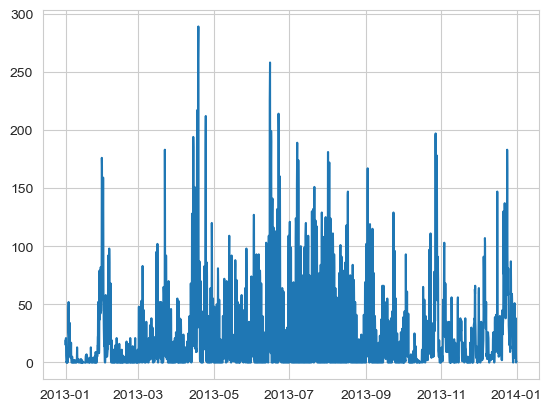

In [18]:
# number can be higher than 181 as there are also generators for other technologies not just electricity -> maybe first only concentrate on AC (main bus)
plt.plot(out_incidence.sum(axis=1))
out_incidence.sum(axis=1).max()

C:\Users\Julian\AppData\Local\Temp\ipykernel_8052\3556787543.py:9: UserWarning:

marker is redundantly defined by the 'marker' keyword argument and the fmt string "x" (-> marker='x'). The keyword argument will take precedence.



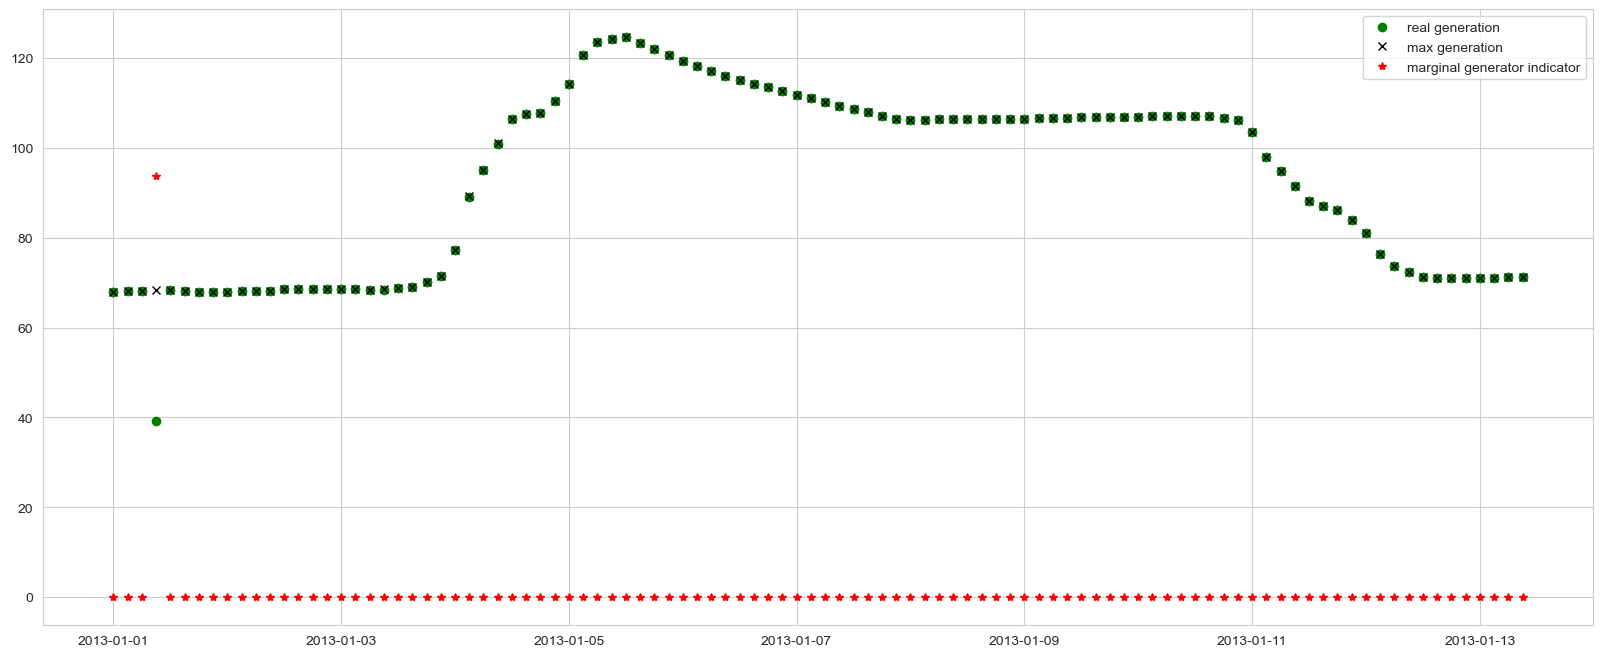

In [19]:
# check results
gen = "SK0 0 ror" # "AT0 1 onwind" # "SK0 0 solar rooftop" # "DE0 10 solar" # AL0 0 solar, AT0 1 onwind
start = 0
end = 100

plt.figure(figsize=(20, 8))
plt.plot(n.generators_t.p[gen][start:end], "o", color="green", label="real generation")
plt.plot(max_out_gen[gen][start:end], "x", color="black", label="max generation")
plt.plot(out_incidence[gen][start:end]*max_out_gen[gen][start:end].mean(), "x", color="red", marker="*", label="marginal generator indicator")
plt.legend()
plt.show()

### Problems
- for very low possible VRE output, the indication is often set but, the technology is surely not the marginal generator (check AT0 1 onwind) first 3 hours (corrected by adding constraint for minimum output of 10 MW)


## Storage Units

In [20]:
# Challenge1: comparing only the actual output with the product of nominal power and maximum output is not sufficient as the storage can be empty / not sufficiently full ?
# Challenge2: the real output can be either positive or negative (when storing energy) -> no problem as threshols only takes values for positive generation
# n.storage_units.p_nom == n.storage_units.p_nom_opt is True -> you can use both
# n.storage_units.index.difference(pd.Index(n.storage_units_t.p.columns)) -> no difference in indices

In [21]:
n.storage_units.index

Index(['AT0 0 hydro', 'AT0 1 PHS', 'AT0 1 hydro', 'AT0 2 PHS', 'AT0 2 hydro',
       'BE0 1 PHS', 'BE0 1 hydro', 'BG0 0 hydro', 'BG0 1 PHS', 'BG0 1 hydro',
       ...
       'SE3 3 hydro', 'SE3 4 hydro', 'SE3 5 hydro', 'SE3 6 PHS', 'SE3 6 hydro',
       'SE3 7 hydro', 'SI0 0 PHS', 'SI0 0 hydro', 'SK0 0 PHS', 'SK0 0 hydro'],
      dtype='object', name='StorageUnit', length=170)

In [22]:
# calculate the possible output for the storage unit for every time step (all static as n.storage_units_t.p_max_pu is empty)
max_output = n.storage_units.p_max_pu * n.storage_units.p_nom_opt
# max_output = pd.DataFrame(max_output.values.reshape(1,170), columns=max_output.index)
# max_output

In [23]:
n.storage_units_t.p_max_pu

StorageUnit
snapshot
2013-01-01 00:00:00
2013-01-01 03:00:00
2013-01-01 06:00:00
2013-01-01 09:00:00
2013-01-01 12:00:00
...
2013-12-31 09:00:00
2013-12-31 12:00:00
2013-12-31 15:00:00


In [24]:
# real output
n.storage_units_t.p

StorageUnit,AT0 0 hydro,AT0 1 PHS,AT0 1 hydro,AT0 2 PHS,AT0 2 hydro,BE0 1 PHS,BE0 1 hydro,BG0 0 hydro,BG0 1 PHS,BG0 1 hydro,...,SE3 3 hydro,SE3 4 hydro,SE3 5 hydro,SE3 6 PHS,SE3 6 hydro,SE3 7 hydro,SI0 0 PHS,SI0 0 hydro,SK0 0 PHS,SK0 0 hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.012865,0.041039,0.003039,-0.009721,0.009953,-0.036106,0.013979,319.190476,72.512364,1165.298713,...,0.003265,0.015847,0.019115,0.043090,288.543736,0.016225,59.590499,730.785534,0.003466,98.603409
2013-01-01 03:00:00,0.012841,0.024226,0.002972,-0.010176,0.009789,-0.011099,0.024839,319.190472,1159.076994,1165.298695,...,0.003257,0.010948,0.012895,0.065493,288.689276,0.011146,40.199534,730.785526,0.015739,94.322064
2013-01-01 06:00:00,0.008043,0.015460,0.002940,-0.040535,0.007463,-0.027069,0.021429,319.189436,0.026051,1165.298007,...,0.004014,0.014472,0.017224,0.064525,288.715495,0.014713,0.001124,730.783770,0.011896,0.054735
2013-01-01 09:00:00,0.002082,-542.779577,0.002591,-1829.290856,0.002801,-0.078550,0.015965,0.014910,-1398.984653,0.018543,...,0.008538,0.015898,0.016398,-91.977821,0.011502,0.016099,-184.992470,0.025293,-1021.272174,0.002086
2013-01-01 12:00:00,0.006093,-0.093714,0.002674,-32.098796,0.006246,-0.184040,0.015972,319.189435,0.045875,1165.298061,...,29.786837,204.697089,176.195500,0.012741,55.011600,197.137294,-0.008166,730.783337,-0.053098,0.010078
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.006801,-2411.990162,0.001668,-0.008033,0.010581,-1163.908127,0.005519,319.189913,0.038533,1165.298066,...,0.006355,0.024361,0.016715,-0.099673,0.053854,0.022366,0.030740,730.785091,-0.094936,78.185793
2013-12-31 12:00:00,0.006966,-1169.808270,0.002522,-0.009887,0.010383,-0.064200,0.008708,319.189958,0.041612,1165.298126,...,0.007661,0.022220,0.023819,-0.162239,0.052338,0.022571,0.007974,730.784440,-0.041091,789.270206
2013-12-31 15:00:00,0.007940,0.258793,0.003204,-0.001086,0.012742,-0.088930,0.008626,319.190484,739.465403,1165.298713,...,0.007500,0.022204,0.023620,-0.098356,0.051981,0.022462,0.267197,730.785448,-0.007880,791.920057


In [25]:
# state of charge (State of charge as calculated by the OPF in MWh)
n.storage_units_t.state_of_charge

StorageUnit,AT0 0 hydro,AT0 1 PHS,AT0 1 hydro,AT0 2 PHS,AT0 2 hydro,BE0 1 PHS,BE0 1 hydro,BG0 0 hydro,BG0 1 PHS,BG0 1 hydro,...,SE3 3 hydro,SE3 4 hydro,SE3 5 hydro,SE3 6 PHS,SE3 6 hydro,SE3 7 hydro,SI0 0 PHS,SI0 0 hydro,SK0 0 PHS,SK0 0 hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,121657.829453,9301.712439,451648.305533,386458.411542,2.026027e+06,4999.266168,93757.191546,378677.130320,4015.557742,1.417548e+06,...,180410.013749,4.688388e+06,2.732513e+06,311.285709,551853.532103,3.899218e+06,768.369342,1.264840e+06,0.313646,1.151015e+06
2013-01-01 03:00:00,121867.651350,9301.611706,452593.694029,386458.427811,2.029001e+06,4999.272299,93808.756444,377650.256431,0.390421,1.413799e+06,...,180584.400488,4.692818e+06,2.735086e+06,311.044167,551431.231069,3.902921e+06,629.109262,1.263024e+06,0.243261,1.150953e+06
2013-01-01 06:00:00,122077.417056,9301.539852,453538.757433,386458.525371,2.031974e+06,4999.323688,93863.830497,376623.371355,0.292603,1.410050e+06,...,180758.125193,4.697232e+06,2.737650e+06,310.805781,551006.800614,3.906609e+06,629.096966,1.261209e+06,0.182177,1.151206e+06
2013-01-01 09:00:00,122287.208694,10711.710760,454483.849288,391211.159165,2.034948e+06,4999.512554,93920.657564,376672.964769,3634.957130,1.410231e+06,...,180930.924539,4.701622e+06,2.740201e+06,549.764987,551541.898243,3.910278e+06,1109.719189,1.261829e+06,2653.522256,1.151459e+06
2013-01-01 12:00:00,122498.561291,10711.941537,455436.032830,391294.547762,2.037943e+06,4999.977200,93976.994302,375687.809655,3634.791434,1.406634e+06,...,181003.682134,4.705310e+06,2.742152e+06,549.702304,551891.244781,3.913273e+06,1109.733844,1.260016e+06,2653.646539,1.151712e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,120416.241172,6266.640983,446054.603412,386458.396131,2.008429e+06,4998.754803,93592.451161,383060.865531,8088.766593,1.433552e+06,...,179709.144617,4.670581e+06,2.722168e+06,310.875922,550922.010254,3.884338e+06,977.581908,1.272180e+06,0.265828,1.158020e+06
2013-12-31 12:00:00,120674.887287,9305.880146,447219.846053,386458.411628,2.012095e+06,4998.903729,93621.709435,382221.598234,8088.614825,1.430488e+06,...,179840.731956,4.673924e+06,2.724110e+06,311.281452,551329.359615,3.887132e+06,977.547053,1.270801e+06,0.361527,1.155764e+06
2013-12-31 15:00:00,120932.988809,9304.971274,448382.647804,386458.401703,2.015753e+06,4999.118232,93650.772912,381382.362851,5527.024780,1.427424e+06,...,179972.240144,4.677266e+06,2.726051e+06,311.521194,551736.463438,3.889924e+06,976.616582,1.269421e+06,0.366431,1.153499e+06


In [26]:
max_output_ts = n.storage_units_t.p.copy()
for snap in n.storage_units_t.p.index:
    max_output_ts.loc[snap] = max_output[n.storage_units_t.p.columns]
max_output_ts

StorageUnit,AT0 0 hydro,AT0 1 PHS,AT0 1 hydro,AT0 2 PHS,AT0 2 hydro,BE0 1 PHS,BE0 1 hydro,BG0 0 hydro,BG0 1 PHS,BG0 1 hydro,...,SE3 3 hydro,SE3 4 hydro,SE3 5 hydro,SE3 6 PHS,SE3 6 hydro,SE3 7 hydro,SI0 0 PHS,SI0 0 hydro,SK0 0 PHS,SK0 0 hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-01-01 03:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-01-01 06:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-01-01 09:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-01-01 12:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-12-31 12:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-12-31 15:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0


In [27]:
# take minimum of state of charge and max_output_ts
# Problem: There are a lot of entries where the ration is larger than 1 if you take the minimum; THis is not the case for skipping this step (maybe skip for now)
# max_output_ts = np.minimum(max_output_ts, n.storage_units_t.state_of_charge)
max_output_ts

StorageUnit,AT0 0 hydro,AT0 1 PHS,AT0 1 hydro,AT0 2 PHS,AT0 2 hydro,BE0 1 PHS,BE0 1 hydro,BG0 0 hydro,BG0 1 PHS,BG0 1 hydro,...,SE3 3 hydro,SE3 4 hydro,SE3 5 hydro,SE3 6 PHS,SE3 6 hydro,SE3 7 hydro,SI0 0 PHS,SI0 0 hydro,SK0 0 PHS,SK0 0 hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-01-01 03:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-01-01 06:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-01-01 09:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-01-01 12:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-12-31 12:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0
2013-12-31 15:00:00,312.0,2412.0,1405.484076,1829.3,4421.62,1164.0,12.735669,319.195414,1399.0,1165.303822,...,93.3,2370.0,1376.834706,92.0,288.87959,1980.552563,185.0,730.79,1021.28,792.0


In [28]:
# compare to real output
out_ratio = n.storage_units_t.p / max_output_ts
out_diff = max_output_ts -  n.storage_units_t.p

In [29]:
out_ratio

StorageUnit,AT0 0 hydro,AT0 1 PHS,AT0 1 hydro,AT0 2 PHS,AT0 2 hydro,BE0 1 PHS,BE0 1 hydro,BG0 0 hydro,BG0 1 PHS,BG0 1 hydro,...,SE3 3 hydro,SE3 4 hydro,SE3 5 hydro,SE3 6 PHS,SE3 6 hydro,SE3 7 hydro,SI0 0 PHS,SI0 0 hydro,SK0 0 PHS,SK0 0 hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0.000041,0.000017,0.000002,-5.313833e-06,2.250947e-06,-0.000031,0.001098,0.999985,0.051832,0.999996,...,0.000035,0.000007,0.000014,0.000468,0.998837,0.000008,0.322111,0.999994,3.393340e-06,0.124499
2013-01-01 03:00:00,0.000041,0.000010,0.000002,-5.562567e-06,2.213868e-06,-0.000010,0.001950,0.999985,0.828504,0.999996,...,0.000035,0.000005,0.000009,0.000712,0.999341,0.000006,0.217295,0.999994,1.541118e-05,0.119094
2013-01-01 06:00:00,0.000026,0.000006,0.000002,-2.215857e-05,1.687920e-06,-0.000023,0.001683,0.999981,0.000019,0.999995,...,0.000043,0.000006,0.000013,0.000701,0.999432,0.000007,0.000006,0.999991,1.164777e-05,0.000069
2013-01-01 09:00:00,0.000007,-0.225033,0.000002,-9.999950e-01,6.335698e-07,-0.000067,0.001254,0.000047,-0.999989,0.000016,...,0.000092,0.000007,0.000012,-0.999759,0.000040,0.000008,-0.999959,0.000035,-9.999923e-01,0.000003
2013-01-01 12:00:00,0.000020,-0.000039,0.000002,-1.754704e-02,1.412641e-06,-0.000158,0.001254,0.999981,0.000033,0.999995,...,0.319259,0.086370,0.127971,0.000138,0.190431,0.099537,-0.000044,0.999991,-5.199126e-05,0.000013
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0.000022,-0.999996,0.000001,-4.391365e-06,2.393123e-06,-0.999921,0.000433,0.999983,0.000028,0.999995,...,0.000068,0.000010,0.000012,-0.001083,0.000186,0.000011,0.000166,0.999993,-9.295756e-05,0.098719
2013-12-31 12:00:00,0.000022,-0.484995,0.000002,-5.404842e-06,2.348146e-06,-0.000055,0.000684,0.999983,0.000030,0.999995,...,0.000082,0.000009,0.000017,-0.001763,0.000181,0.000011,0.000043,0.999992,-4.023461e-05,0.996553
2013-12-31 15:00:00,0.000025,0.000107,0.000002,-5.938351e-07,2.881746e-06,-0.000076,0.000677,0.999985,0.528567,0.999996,...,0.000080,0.000009,0.000017,-0.001069,0.000180,0.000011,0.001444,0.999994,-7.715911e-06,0.999899


In [30]:
#out_diff

### Results

In [31]:
# indicate which storage_unit is marginal storage_unit
th_ratio = 0.95
th_prod_rel = 0.05
th_prod_abs = 10

# ratio has to be lower than threshold
out_ratio[out_ratio < th_ratio] = 0.5 # th_ratio
# output has to be greater than threshold (relatively to max_output) and greater than th_prod_abs MW
out_prod = n.storage_units_t.p.copy()
out_prod[(out_prod > (max_output_ts*th_prod_rel)) & (out_prod > th_prod_abs)] = 0.5 # th_prod
out_incidence_su = out_ratio + out_prod
out_incidence_su[out_incidence_su != 1] = 0
out_incidence_su = out_incidence_su.astype(int)
out_incidence_su

StorageUnit,AT0 0 hydro,AT0 1 PHS,AT0 1 hydro,AT0 2 PHS,AT0 2 hydro,BE0 1 PHS,BE0 1 hydro,BG0 0 hydro,BG0 1 PHS,BG0 1 hydro,...,SE3 3 hydro,SE3 4 hydro,SE3 5 hydro,SE3 6 PHS,SE3 6 hydro,SE3 7 hydro,SI0 0 PHS,SI0 0 hydro,SK0 0 PHS,SK0 0 hydro
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
2013-01-01 03:00:00,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
2013-01-01 06:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 09:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 12:00:00,0,0,0,0,0,0,0,0,0,0,...,1,1,1,0,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2013-12-31 12:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-12-31 15:00:00,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


82

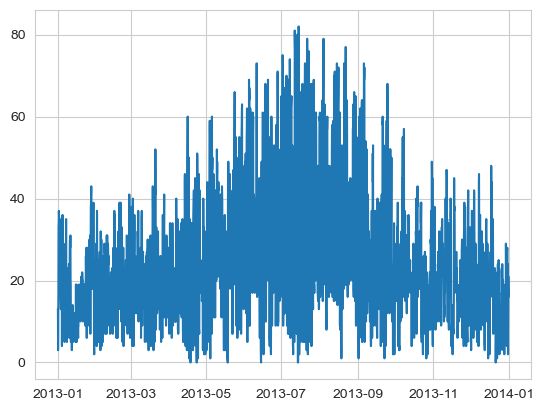

In [32]:
# number cannot be higher than 181 as PHS and hydro both feed into the AC bus (they lie at the bus directly)
plt.plot(out_incidence_su.sum(axis=1))
out_incidence_su.sum(axis=1).max()

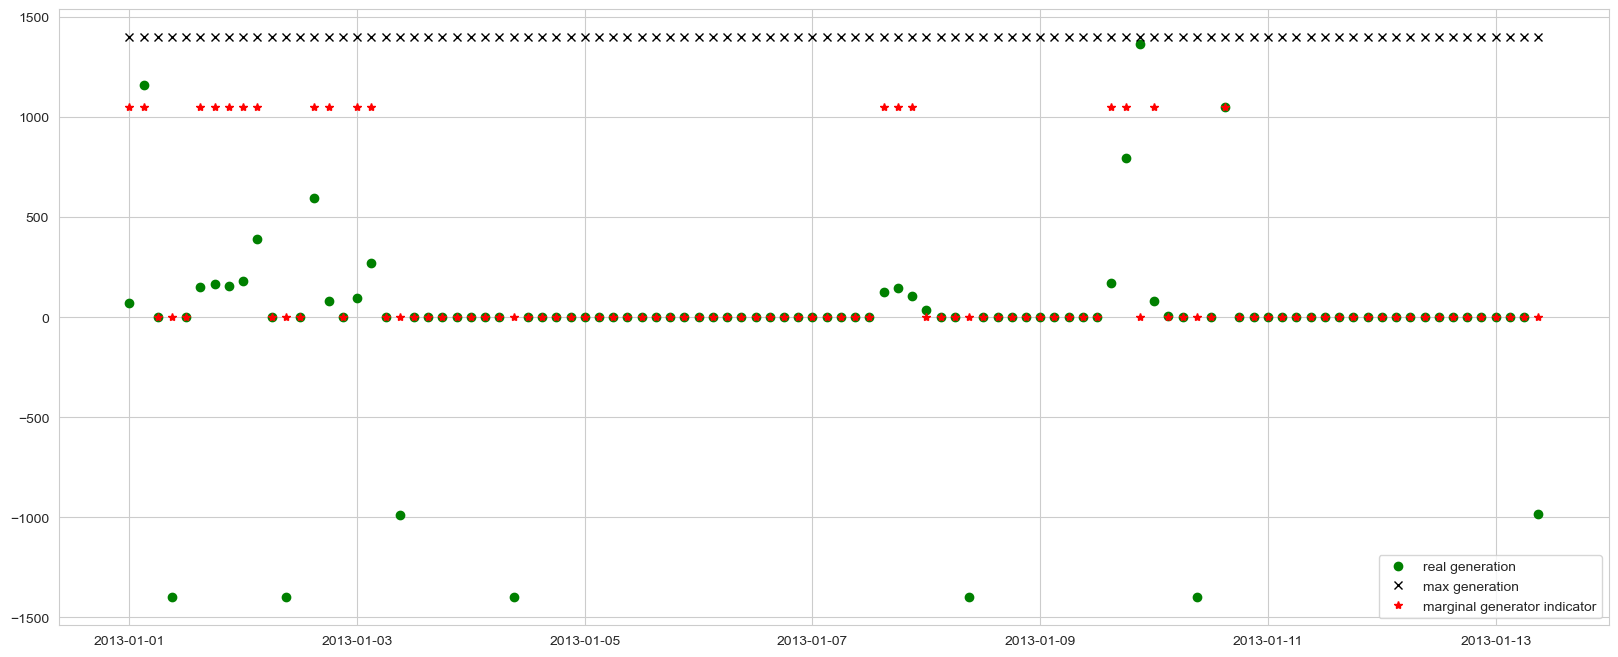

In [33]:
# check results
su = "BG0 1 PHS" # "BG0 1 hydro"; BG0 1 PHS
start = 0
end = 100

plt.figure(figsize=(20, 8))
plt.plot(n.storage_units_t.p[su][start:end], "o", color="green", label="real generation")
plt.plot(max_output_ts[su][start:end], "x", color="black", label="max generation")
plt.plot(out_incidence_su[su][start:end]*max_output_ts[su][start:end].mean()*0.75, ls="", color="red", marker="*", label="marginal generator indicator")
plt.legend()
plt.show()

## Links
Challenges:
- Links with multiple outputs: Links can also be defined with multiple outputs in fixed ratio to the power in the single input by defining new columns bus2, bus3, etc. (bus followed by an integer) in network.links along with associated columns for the efficiencies efficiency2, efficiency3, etc. The different outputs are then equal to the input multiplied by the corresponding efficiency;
- How to handle links with multiple outputs?
- Links are connected to stores which might be empty / not sufficiently full!

In [34]:
# specify method to determine marginal generator: 1 means using the p_max_pu * p_nom_opt as maximum capacity and 2 means using the maximum real output as capcity
method = 2 #

In [35]:
# n.links.index.difference(pd.Index(n.links_t.p0.columns)) is empty -> no difference in indices

In [36]:
# Active power at bus0 (positive if branch is withdrawing power from bus0)
# only negative values would be relevant here (negative means generating energy)
# TODO: negative values only exist for the electricity distribution grid (skip for now)
n.links_t.p0[n.links_t.p0 < 0].sum()

Link
12998                           -1.502215e+06
14531                           -4.246201e+05
14537                            0.000000e+00
14538                            0.000000e+00
14539                            0.000000e+00
                                     ...     
gas for industry                 0.000000e+00
gas for industry CC              0.000000e+00
process emissions                0.000000e+00
solid biomass for industry       0.000000e+00
solid biomass for industry CC    0.000000e+00
Length: 8375, dtype: float64

In [37]:
# flip sign to make generation poitive
n_links_p1 = n.links_t.p1 *-1
n_links_p1

Link,12998,14531,14537,14538,14539,14540,14542,14547,14550,14551,...,T20,T21,T22,T23,T24,gas for industry,gas for industry CC,process emissions,solid biomass for industry,solid biomass for industry CC
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,-373.224322,-249.993237,-0.0,-0.0,-0.0,-0.0,599.976038,-499.963378,999.540578,-597.418961,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.032368,30237.410554,0.001197,0.017103,80182.631299
2013-01-01 03:00:00,-437.541123,-249.993058,-0.0,-0.0,-0.0,-0.0,516.626986,-499.965632,999.966753,-599.975228,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.032540,30237.410382,0.001188,0.017149,80182.631253
2013-01-01 06:00:00,515.030831,-249.993312,-0.0,-0.0,-0.0,-0.0,22.926537,-499.996982,999.971128,-599.927696,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.032681,30237.410241,0.001184,0.017191,80182.631211
2013-01-01 09:00:00,999.992935,-249.986233,-0.0,-0.0,-0.0,-0.0,-0.003338,499.961155,999.971371,-599.972055,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.032795,30237.410127,0.001184,0.017225,80182.631177
2013-01-01 12:00:00,-999.753630,-249.992932,-0.0,-0.0,-0.0,-0.0,-17.666072,336.640918,999.971740,-599.885795,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.032924,30237.409998,0.001187,0.017272,80182.631130
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,-234.716347,-249.992745,-0.0,-0.0,-0.0,-0.0,51.158434,-499.954895,560.748082,-599.886990,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.034309,30237.408613,0.001410,0.017514,80182.630888
2013-12-31 12:00:00,-999.993634,-249.992624,-0.0,-0.0,-0.0,-0.0,17.963294,-499.957181,347.496530,-599.886507,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.034310,30237.408612,0.001408,0.017511,80182.630891
2013-12-31 15:00:00,45.771531,-249.992412,-0.0,-0.0,-0.0,-0.0,8.645707,-499.940458,998.984391,-599.884190,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.034304,30237.408618,0.001404,0.017508,80182.630894


### Determine maximum possible output

In [38]:
# Limit of active power which can pass through link (n.links.p_nom can not be used)
# Optimised nominal power
n.links.p_nom_opt.head()

Link
14547     500.0
5686      400.0
14539       0.0
12998    1000.0
14562    2000.0
Name: p_nom_opt, dtype: float64

In [39]:
# some links have a static p_max_pu value and some have an alternating (series)
index_series_li = n.links_t.p_max_pu.columns
index_static_li = n.links.index.difference(n.links_t.p_max_pu.columns)

In [40]:
# calculate the possible output for the link for every time step

if method == 1:
    # use p_max_pu * p_nom_op
    max_output_links_static = n.links.loc[index_static_li].p_max_pu * n.links.loc[index_static_li].p_nom_opt
elif method == 2:
    # alternatively use the maximum of the real output and set it as the maximum capacity
    max_output_links_static= n_links_p1[index_static_li].max()

In [41]:
# make ts of max_output_links_static
max_output_links_ts_static = n.links_t.p0[index_static_li].copy()
for snap in n.links_t.p0.index:
    max_output_links_ts_static.loc[snap] = max_output_links_static[index_static_li]

In [42]:
# calc time series of time dependent p_max_pu links
max_output_links_ts_series = n.links_t.p_max_pu * n.links.p_nom_opt[index_series_li]

In [43]:
# merge static and series values and reorder columns
max_output_links_ts = pd.concat([max_output_links_ts_static, max_output_links_ts_series], axis=1)[n.links_t.p0.columns]
max_output_links_ts

Link,12998,14531,14537,14538,14539,14540,14542,14547,14550,14551,...,T20,T21,T22,T23,T24,gas for industry,gas for industry CC,process emissions,solid biomass for industry,solid biomass for industry CC
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,999.999197,249.99965,-0.0,-0.0,-0.0,-0.0,599.999621,499.999469,999.999713,599.999619,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.034898,30237.410554,0.001428,0.017695,80182.631299
2013-01-01 03:00:00,999.999197,249.99965,-0.0,-0.0,-0.0,-0.0,599.999621,499.999469,999.999713,599.999619,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.034898,30237.410554,0.001428,0.017695,80182.631299
2013-01-01 06:00:00,999.999197,249.99965,-0.0,-0.0,-0.0,-0.0,599.999621,499.999469,999.999713,599.999619,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.034898,30237.410554,0.001428,0.017695,80182.631299
2013-01-01 09:00:00,999.999197,249.99965,-0.0,-0.0,-0.0,-0.0,599.999621,499.999469,999.999713,599.999619,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.034898,30237.410554,0.001428,0.017695,80182.631299
2013-01-01 12:00:00,999.999197,249.99965,-0.0,-0.0,-0.0,-0.0,599.999621,499.999469,999.999713,599.999619,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.034898,30237.410554,0.001428,0.017695,80182.631299
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,999.999197,249.99965,-0.0,-0.0,-0.0,-0.0,599.999621,499.999469,999.999713,599.999619,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.034898,30237.410554,0.001428,0.017695,80182.631299
2013-12-31 12:00:00,999.999197,249.99965,-0.0,-0.0,-0.0,-0.0,599.999621,499.999469,999.999713,599.999619,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.034898,30237.410554,0.001428,0.017695,80182.631299
2013-12-31 15:00:00,999.999197,249.99965,-0.0,-0.0,-0.0,-0.0,599.999621,499.999469,999.999713,599.999619,...,-0.0,-0.0,-0.0,-0.0,-0.0,0.034898,30237.410554,0.001428,0.017695,80182.631299


In [44]:
#TODO: add step to check the charging state of the store

In [45]:
# compare to real output
out_ratio_links = n_links_p1 / max_output_links_ts
out_diff_links = max_output_links_ts - n_links_p1

In [46]:
out_ratio_links.describe()

Link,12998,14531,14537,14538,14539,14540,14542,14547,14550,14551,...,T20,T21,T22,T23,T24,gas for industry,gas for industry CC,process emissions,solid biomass for industry,solid biomass for industry CC
count,2920.000000,2920.000000,0.0,0.0,0.0,0.0,2920.000000,2920.000000,2920.000000,2920.000000,...,0.0,0.0,0.0,0.0,0.0,2920.000000,2.920000e+03,2920.000000,2920.000000,2.920000e+03
mean,-0.324658,-0.245037,NaN,NaN,NaN,NaN,-0.092228,-0.173899,0.378848,0.047802,...,NaN,NaN,NaN,NaN,NaN,0.988924,9.999999e-01,0.917687,0.992123,1.000000e+00
std,0.710355,0.907575,NaN,NaN,NaN,NaN,0.904404,0.941469,0.889692,0.958040,...,NaN,NaN,NaN,NaN,NaN,0.007381,8.519191e-09,0.037501,0.003111,6.866131e-10
min,-1.000000,-1.000000,NaN,NaN,NaN,NaN,-1.000000,-0.999999,-1.000000,-1.000000,...,NaN,NaN,NaN,NaN,NaN,0.927515,9.999999e-01,0.829231,0.966557,1.000000e+00
25%,-0.999874,-0.999901,NaN,NaN,NaN,NaN,-0.999946,-0.999930,-0.943936,-0.999846,...,NaN,NaN,NaN,NaN,NaN,0.988659,9.999999e-01,0.894362,0.990809,1.000000e+00
50%,-0.561594,-0.896176,NaN,NaN,NaN,NaN,-0.468248,-0.894257,0.999978,0.466861,...,NaN,NaN,NaN,NaN,NaN,0.991231,9.999999e-01,0.922190,0.992865,1.000000e+00
75%,0.185403,0.999388,NaN,NaN,NaN,NaN,0.999700,0.999925,0.999991,0.999970,...,NaN,NaN,NaN,NaN,NaN,0.992798,9.999999e-01,0.931797,0.993525,1.000000e+00
max,1.000000,1.000000,NaN,NaN,NaN,NaN,1.000000,1.000000,1.000000,1.000000,...,NaN,NaN,NaN,NaN,NaN,1.000000,1.000000e+00,1.000000,1.000000,1.000000e+00


### Results

In [47]:
# indicate which link is marginal generator for p1
th_ratio = 0.95
th_prod_rel = 0.05
th_prod_abs = 10

# ratio has to be lower than threshold
out_ratio_links[out_ratio_links < th_ratio] = 0.5 # th_ratio
# output has to be greater than threshold (relatively to max_output) and greater than th_prod_abs MW
out_prod_links = n_links_p1.copy()
out_prod_links[(out_prod_links > (max_output_links_ts*th_prod_rel)) & (out_prod_links > th_prod_abs)] = 0.5 # th_prod
out_incidence_li = out_ratio_links + out_prod_links
out_incidence_li[out_incidence_li != 1] = 0
out_incidence_li = out_incidence_li.astype(int)
out_incidence_li

Link,12998,14531,14537,14538,14539,14540,14542,14547,14550,14551,...,T20,T21,T22,T23,T24,gas for industry,gas for industry CC,process emissions,solid biomass for industry,solid biomass for industry CC
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 03:00:00,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 06:00:00,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 09:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2013-01-01 12:00:00,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-31 09:00:00,0,0,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2013-12-31 12:00:00,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2013-12-31 15:00:00,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [48]:
out_incidence_li.describe()

Link,12998,14531,14537,14538,14539,14540,14542,14547,14550,14551,...,T20,T21,T22,T23,T24,gas for industry,gas for industry CC,process emissions,solid biomass for industry,solid biomass for industry CC
count,2920.000000,2920.000000,2920.0,2920.0,2920.0,2920.0,2920.000000,2920.000000,2920.000000,2920.000000,...,2920.0,2920.0,2920.0,2920.0,2920.0,2920.0,2920.0,2920.0,2920.0,2920.0
mean,0.201370,0.060959,0.0,0.0,0.0,0.0,0.150342,0.037329,0.044178,0.052397,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
std,0.401092,0.239296,0.0,0.0,0.0,0.0,0.357468,0.189599,0.205526,0.222865,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25%,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
50%,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
75%,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
max,1.000000,1.000000,0.0,0.0,0.0,0.0,1.000000,1.000000,1.000000,1.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


2773

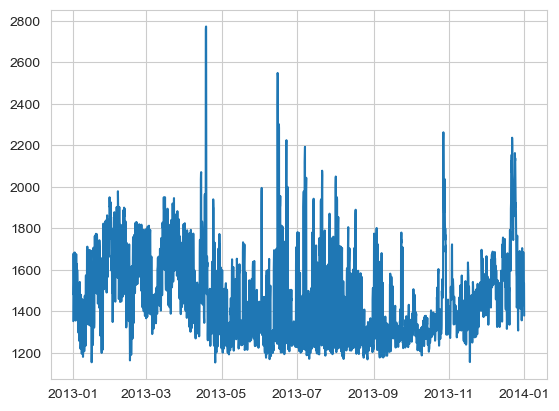

In [49]:
# number can be higher than 181 as there are also generators for other technologies not just electricity -> maybe first only concentrate on AC (main bus)
plt.plot(out_incidence_li.sum(axis=1))
out_incidence_li.sum(axis=1).max()

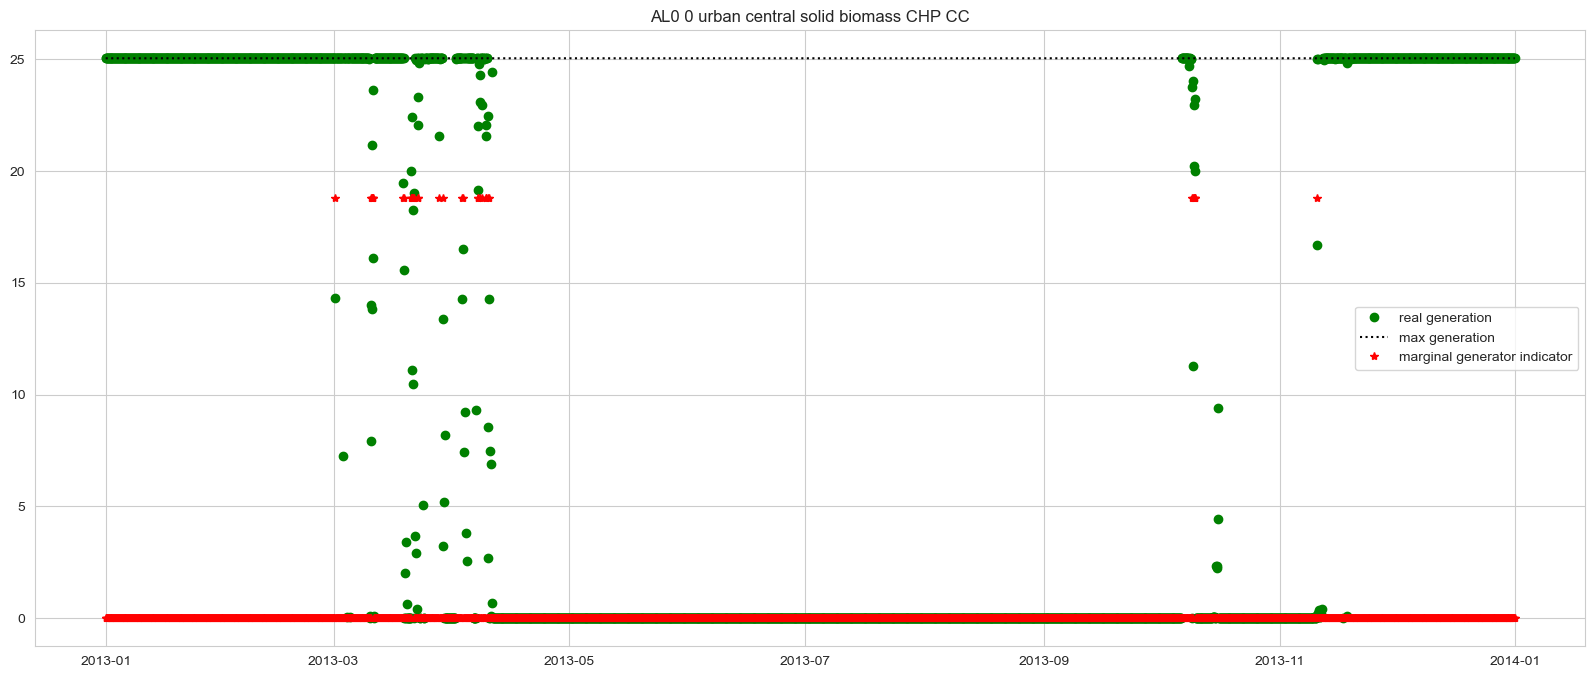

In [50]:
# check results
li = "AL0 0 urban central solid biomass CHP CC" # "AL0 0 residential rural ground heat pump" #DE0 0 H2 Fuel Cell" # "AL0 0 urban central solid biomass CHP CC"# "DE0 0 H2 Fuel Cell" # "SE3 6 urban central resistive heater"
start = 0
end = 2920

plt.figure(figsize=(20, 8))
plt.plot(n_links_p1[li][start:end], "o", color="green", label="real generation")
plt.plot(max_output_links_ts[li][start:end], ":", color="black", label="max generation")
plt.plot(out_incidence_li[li][start:end]*max_output_links_ts[li][start:end].mean()*0.75, ls="", color="red", marker="*", label="marginal generator indicator")
plt.title(f"{li}")
plt.legend()
plt.show()

### Problems
- For "AL0 0 urban central solid biomass CHP CC" the max generation is not the real maximum possible output; same for "AL0 0 urban central solid biomass CHP" -> this can be obtained as the real generation never reaches the max generation (same for "DE0 0 H2 Fuel Cell")
- For a lot of links the real ouptut is higher thant he maximum output: "AL0 0 residential rural ground heat pump"

Possible solution:
- use the maximum of the real output and the theoretical maximum output for the static links


In [51]:
# check if maximum output is ever reached (only check for static links)
ratio = pd.DataFrame(n_links_p1[index_static_li].max() / max_output_links_static).rename(columns={0: "data"})

In [52]:
# this is 0 if you use the real maximum output as capacity (method2)
ratio[ratio.data > 1]

,data
Link,


In [53]:
# 4757 for method 1; 0 for method 2
ratio[ratio.data < 0.9]

,data
Link,


In [54]:
# good cases
# 2156 for method 1; 0 for method 2
ratio[(ratio.data > 0.9) & (ratio.data <= 1)]

,data
Link,
12998,1.0
14531,1.0
14542,1.0
14547,1.0
14550,1.0
...,...
gas for industry,1.0
gas for industry CC,1.0
process emissions,1.0


## Determine marginal generator

In [55]:
assert 0

AssertionError: 

In [ ]:
%%time
# create empty df (takes 2 mins)
mg = pd.DataFrame(index=n.buses_t.p.index, columns=n.buses.index)
for col in mg.columns:
    mg[col] = [[] for _ in range(len(mg))]
mg

In [ ]:
%%time
# assign marginal generator for every time step and carrier bus (takes <20 mins)
for snap in out_incidence.index:
    for gen in out_incidence.columns:
        if out_incidence.loc[snap,gen] == 1:
            mg.loc[snap,n.generators.bus[gen]].append(gen)
    for su in  out_incidence_su.columns:
        if out_incidence_su.loc[snap,su] == 1:
            mg.loc[snap,n.storage_units.bus[su]].append(su)
    for li in  out_incidence_li.columns:
            if out_incidence_li.loc[snap,li] == 1:
                mg.loc[snap,n.links.bus1[li]].append(li)

In [ ]:
# save
mg.to_csv("../data/processed/mg_gen_su_li_v1_method2.csv")

In [70]:
# read back with snapshots as Datetime Index and Cells as lists
mg_back = pd.read_csv(filepath_or_buffer="../data/processed/mg_gen_su_li_v1_method1.csv", index_col="snapshot", parse_dates=True, converters={col: ast.literal_eval for col in n.buses.index})

In [71]:
mg = mg_back

In [72]:
mg.head()

,AL0 0,AT0 0,AT0 1,AT0 2,BA0 0,BE0 0,BE0 1,BE0 2,BE0 3,BE0 4,...,SE3 0 home battery,SE3 1 home battery,SE3 2 home battery,SE3 3 home battery,SE3 4 home battery,SE3 5 home battery,SE3 6 home battery,SE3 7 home battery,SI0 0 home battery,SK0 0 home battery
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01 00:00:00,"[AL0 0 urban central gas CHP, AL0 0 urban cent...",[AT0 0 urban central solid biomass CHP CC],[AT0 1 urban central solid biomass CHP CC],[AT0 2 urban central solid biomass CHP CC],"[BA0 0 urban central gas CHP, BA0 0 urban cent...",[BE0 0 battery discharger],[BE0 1 urban central solid biomass CHP CC],[BE0 2 urban central solid biomass CHP CC],[BE0 3 urban central solid biomass CHP CC],[BE0 4 urban central solid biomass CHP CC],...,[],[],[],[],[],[],[],[],[],[]
2013-01-01 03:00:00,"[AL0 0 urban central gas CHP, AL0 0 urban cent...","[AT0 0 urban central gas CHP, AT0 0 urban cent...",[AT0 1 urban central solid biomass CHP CC],[AT0 2 urban central solid biomass CHP CC],"[BA0 0 urban central gas CHP, BA0 0 urban cent...",[BE0 0 battery discharger],"[BE0 1 battery discharger, BE0 1 urban central...",[BE0 2 urban central solid biomass CHP CC],[BE0 3 urban central solid biomass CHP CC],[BE0 4 urban central solid biomass CHP CC],...,[],[],[],[],[],[],[],[],[],[]
2013-01-01 06:00:00,[AL0 0 urban central solid biomass CHP CC],[AT0 0 urban central solid biomass CHP CC],[AT0 1 urban central solid biomass CHP CC],[AT0 2 urban central solid biomass CHP CC],[BA0 0 urban central solid biomass CHP CC],[BE0 0 battery discharger],[BE0 1 urban central solid biomass CHP CC],[BE0 2 urban central solid biomass CHP CC],[BE0 3 urban central solid biomass CHP CC],[BE0 4 urban central solid biomass CHP CC],...,[],[],[],[],[],[],[],[],[],[]
2013-01-01 09:00:00,[AL0 0 urban central solid biomass CHP CC],[AT0 0 urban central solid biomass CHP CC],[AT0 1 urban central solid biomass CHP CC],[AT0 2 urban central solid biomass CHP CC],[BA0 0 urban central solid biomass CHP CC],[BE0 0 battery discharger],[BE0 1 urban central solid biomass CHP CC],[BE0 2 urban central solid biomass CHP CC],[BE0 3 urban central solid biomass CHP CC],[BE0 4 urban central solid biomass CHP CC],...,[],[],[],[],[],[],[],[],[],[]
2013-01-01 12:00:00,[AL0 0 urban central solid biomass CHP CC],[AT0 0 urban central solid biomass CHP CC],[AT0 1 urban central solid biomass CHP CC],[AT0 2 urban central solid biomass CHP CC],[BA0 0 urban central solid biomass CHP CC],[],[BE0 1 urban central solid biomass CHP CC],[BE0 2 urban central solid biomass CHP CC],[BE0 3 urban central solid biomass CHP CC],[BE0 4 urban central solid biomass CHP CC],...,[],[],[],[],[],[],[],[],[],[]


#### Plot for one bus

In [73]:
bus = "AL0 0" # "AL0 0" # "DE0 0"
df = pd.concat([mg[bus], n.buses_t.p[bus], n.buses_t.marginal_price[bus]], axis=1)
df.columns = [f"{bus}_mg", f"{bus}_p", f"{bus}_lmp"]
df[f"{bus}_mg labels"] = df[f"{bus}_mg"].astype(str)
df

,AL0 0_mg,AL0 0_p,AL0 0_lmp,AL0 0_mg labels
snapshot,,,,
2013-01-01 00:00:00,"[AL0 0 urban central gas CHP, AL0 0 urban cent...",-608.163407,208.089324,"['AL0 0 urban central gas CHP', 'AL0 0 urban c..."
2013-01-01 03:00:00,"[AL0 0 urban central gas CHP, AL0 0 urban cent...",-581.055247,208.030183,"['AL0 0 urban central gas CHP', 'AL0 0 urban c..."
2013-01-01 06:00:00,[AL0 0 urban central solid biomass CHP CC],1754.697653,153.808216,['AL0 0 urban central solid biomass CHP CC']
2013-01-01 09:00:00,[AL0 0 urban central solid biomass CHP CC],2405.927337,89.821566,['AL0 0 urban central solid biomass CHP CC']
2013-01-01 12:00:00,[AL0 0 urban central solid biomass CHP CC],1066.208332,153.339481,['AL0 0 urban central solid biomass CHP CC']
...,...,...,...,...
2013-12-31 09:00:00,"[AL0 0 urban central gas CHP, AL0 0 urban cent...",408.769997,199.844657,"['AL0 0 urban central gas CHP', 'AL0 0 urban c..."
2013-12-31 12:00:00,"[AL0 0 urban central gas CHP, AL0 0 urban cent...",151.545199,199.855407,"['AL0 0 urban central gas CHP', 'AL0 0 urban c..."
2013-12-31 15:00:00,"[AL0 0 battery discharger, AL0 0 urban central...",3009.872193,208.203744,"['AL0 0 battery discharger', 'AL0 0 urban cent..."


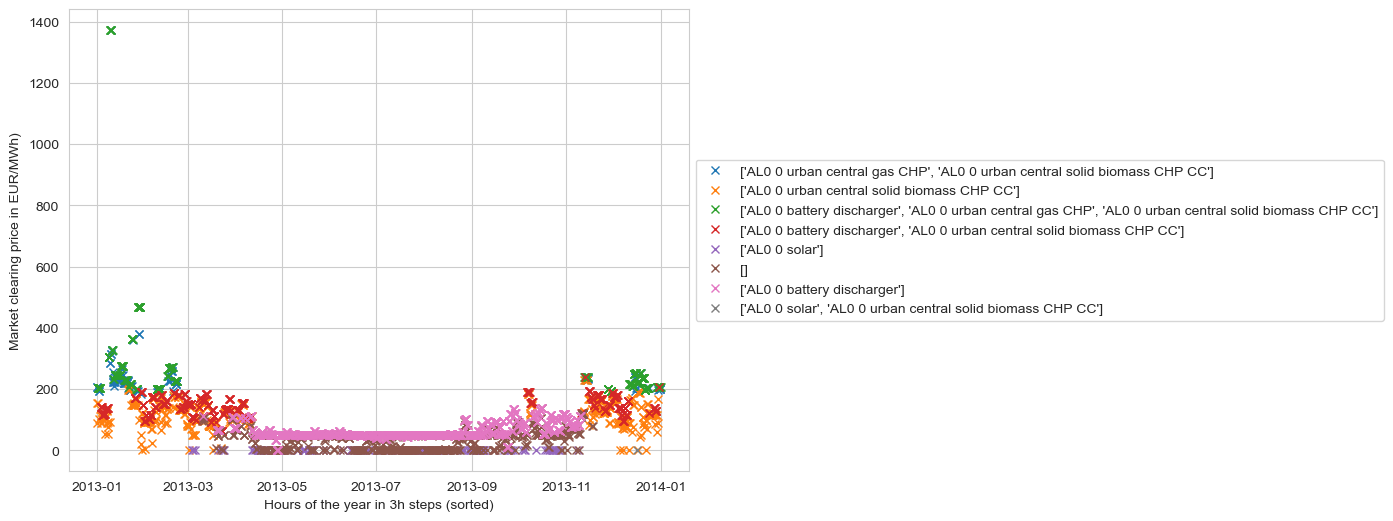

In [74]:
# lmp per marginal generator
plt.figure(figsize=(8, 6))
for label in df[f"{bus}_mg"].astype(str).unique():
    plt.plot(df[df[f"{bus}_mg labels"] == label][f"{bus}_lmp"], "x", label=label)

# plt.ylim(-100, 500)
plt.xlabel("Hours of the year in 3h steps (sorted)")
plt.ylabel("Market clearing price in EUR/MWh)")
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

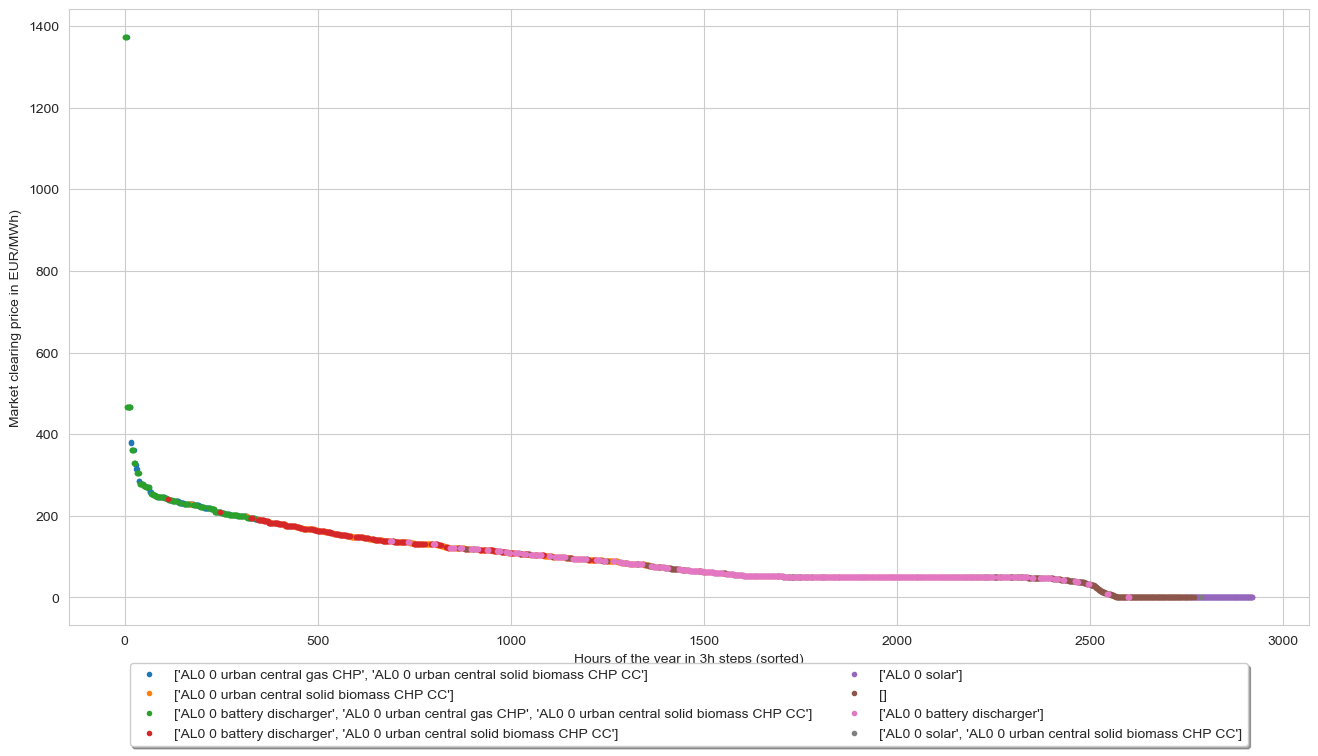

In [75]:
df2 = df.sort_values(by=[f"{bus}_lmp"], ascending=False)
df2.index = np.arange(1, len(df)+1)

# price duration curve per region
plt.figure(figsize=(16, 8))
for label in df[f"{bus}_mg"].astype(str).unique():
    plt.plot(df2[df2[f"{bus}_mg labels"] == label][f"{bus}_lmp"], ".", label=label)

# plt.ylim(-100, 500)
plt.xlabel("Hours of the year in 3h steps (sorted)")
plt.ylabel("Market clearing price in EUR/MWh)")
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05),fancybox=True, shadow=True, ncol=2)
plt.show()

In [64]:
# get counts of marginal generators and labels
# labels
df2[f"{bus}_mg labels"].value_counts()

[]                                                             2852
['DE0 0 urban central gas CHP']                                  40
['DE0 0 battery discharger']                                     24
['DE0 0 OCGT', 'DE0 0 urban central gas CHP']                     1
['DE0 0 OCGT']                                                    1
['DE0 0 battery discharger', 'DE0 0 urban central gas CHP']       1
['DE0 0 H2 Fuel Cell']                                            1
Name: DE0 0_mg labels, dtype: int64

In [65]:
# single marginal generators
mgs = []
for item in df2[f"{bus}_mg"]:
    mgs.extend(item)
mgs = set(mgs)
mgs

{'DE0 0 H2 Fuel Cell',
 'DE0 0 OCGT',
 'DE0 0 battery discharger',
 'DE0 0 urban central gas CHP'}

In [66]:
# single counts / counts of marginal generators
df2[f"{bus}_mg"].apply(','.join).astype(str).str.get_dummies(sep=',').sum().sort_values(ascending=False)

DE0 0 urban central gas CHP    42
DE0 0 battery discharger       25
DE0 0 OCGT                      2
DE0 0 H2 Fuel Cell              1
dtype: int64

In [ ]:
assert 0

## Determine marginal price

### Investigate case
-> power_balance notebook

In [ ]:
mg_back

In [ ]:
n.buses.loc[pd.Index(n.stores.bus.values)].location

In [ ]:
pd.Index(n.stores.bus.values)

In [ ]:
pd.Index(n.stores.bus.values)

In [ ]:
n.stores.bus.values

### ToDO

- Für einzelne Fälle rausfinden welche die marginal generators sind und deren lmp nachvollziehen. Dann damit die anderen marginal generator berechnen
- idea: if the net flow away from a bus is positive this means that the marginal generator has to be at the bus? -> no, only if all flows away from the bus are positive

In [ ]:
# Lines (what reaches bus?)
# 1. sum of power @ lines with bus as bus0 and p0 (Active power at bus0 (positive if branch is withdrawing power from bus0)
n.lines_t.p0[n.lines[n.lines.bus0 == bus].index].sum(axis=1)
# 2. sum of power @ lines with bus as bus1 and p1 (Active power at bus1 (positive if branch is withdrawing power from bus1)
n.lines_t.p1[n.lines[n.lines.bus1 == bus].index].sum(axis=1)
# sum (if negative power is feed into bus)
lines = n.lines_t.p0[n.lines[n.lines.bus0 == bus].index].sum(axis=1) + n.lines_t.p1[n.lines[n.lines.bus1 == bus].index].sum(axis=1)
lines[snapshot]

In [ ]:
# loads
loads_index = n.loads[[s in buses for s in n.loads.bus]].bus.index
# active power at bus (positive if net load) in MW
n.loads_t.p.loc[snapshot, loads_index]#.sum()

In [ ]:
# generation in whole region
gens_index = n.generators[[s in buses for s in n.generators.bus]].bus.index
# active power at bus (positive if net generation) in MW
n.generators_t.p.loc[snapshot, gens_index]#.sum(axis=1)

In [ ]:
# generation directly connected to bus
gens_index_direct = n.generators[n.generators.bus == bus].bus.index
n.generators_t.p.loc[snapshot, gens_index_direct]#.sum(axis=1)

In [ ]:
# storages
storage_index = n.storage_units[[s in buses for s in n.storage_units.bus]].bus.index
# active power at bus (positive if net generation) in MW
n.storage_units_t.p.loc[snapshot, storage_index]#.sum(axis=1)

In [ ]:
# storage directly at bus
storage_index_direct = n.storage_units[n.storage_units.bus == bus].bus.index
n.storage_units_t.p.loc[snapshot, storage_index_direct]#.sum(axis=1)

In [ ]:
# stores
stores_index = n.stores[[s in buses for s in n.stores.bus]].bus.index
# active power at bus (positive if net generation) in MW
n.stores_t.p.loc[snapshot, stores_index]#.sum(axis=1)

In [ ]:
# stores directly at bus
stores_index_direct = n.stores[n.stores.bus == bus].bus.index
# active power at bus (positive if net generation) in MW
n.stores_t.p.loc[snapshot, stores_index_direct]#.sum(axis=1)

In [ ]:
# link

In [ ]:
n.links[n.links.bus0 == bus]

In [ ]:
n.links[n.links.bus1 == bus]

In [ ]:
# Links (what reaches bus?)
# 1. sum of power @ links with bus as bus0 and p0 (Active power at bus0 (positive if branch is withdrawing power from bus0)
n.links_t.p0[n.links[n.links.bus0 == bus].index].sum(axis=1)
# 2. sum of power @ links with bus as bus1 and p1 (Active power at bus1 (positive if branch is withdrawing power from bus1)
n.links_t.p1[n.links[n.links.bus1 == bus].index].sum(axis=1)
# sum (if negative power is feed into bus)
links_sum = n.links_t.p0[n.links[n.links.bus0 == bus].index].sum(axis=1) + n.links_t.p1[n.links[n.links.bus1 == bus].index].sum(axis=1)
links_sum[snapshot]

In [ ]:
n.links_t.p0.loc[snapshot , n.links[n.links.bus0 == bus].index]

In [ ]:
n.links_t.p1.loc[snapshot , n.links[n.links.bus1 == bus].index]

In [ ]:
# aggregation for bus0
# balance of electricity feed in and withdrawal via lines
li = lines[snapshot]
# load at direct bus (not other technologies)
lo = n.loads_t.p.loc[snapshot, loads_index][bus].sum()
# generation at direct bus (not other technologies)
gen = n.generators_t.p.loc[snapshot, gens_index_direct].sum()
lk = links_sum[snapshot]

gen - li - lo - lk

In [ ]:
n.loads_t.p.loc[snapshot, loads_index][bus]

In [ ]:
n.buses_t.marginal_price[buses]

In [ ]:
n.stores

In [ ]:
# 17 buses in region AL0 0
n.buses[n.buses.location == "AL0 0"]

In [ ]:
# 181 regions and EU
n.buses.location.unique()

In [ ]:
n.loads[['AL0 0' in s for s in n.loads.index]]

In [ ]:
n.loads.bus.unique()

In [ ]:
n.generators.bus.unique()

In [ ]:
n.storage_units.bus

In [ ]:
n.stores.bus

In [ ]:
n.loads_t.p

In [ ]:
n.loads_t.p.loc["2013-01-02 03:00:00", ['AL0 0' in s for s in n.loads_t.p.columns]]

In [ ]:
n.loads_t.p

In [ ]:
n.loads_t.p_set.loc["2013-01-02 00:00:00", ['AL0 0' in s for s in n.loads_t.p_set.columns]]

In [ ]:
n.buses[['AL0 0' in s for s in n.buses.index]]

In [ ]:
# active power at bus (positive if net generation at bus) (MW)
n.buses_t.p
# 608 MWh missing at ALO 0 that are feed in from other buses / nodes via lines 1,2,3,4
1639.391422 - 1053.551832 - 269.964278

In [ ]:
# marginal cost of generator in currency/MWh
n.generators[['AL0 0' in s for s in n.generators.index]]

In [ ]:
# actual dispatch of the generator
n.generators_t.p.loc["2013-01-02 00:00:00", ['AL0 0' in s for s in n.generators_t.p.columns]]

In [ ]:
n.storage_units[['AL0 0' in s for s in n.storage_units.index]]

In [ ]:
n.storage_units.marginal_cost.describe()

In [ ]:
# Locational marginal price from LOPF from power balance constraint (currency/MWh)
plt.plot(n.buses_t.marginal_price['AL0 0'])

In [ ]:
n.stores[['AL0 0' in s for s in n.stores.index]]

In [ ]:
# active power at bus (positive if net generation) (MW)
n.stores_t.p.loc["2013-01-02 00:00:00", ['AL0 0' in s for s in n.stores_t.p.columns]]

In [ ]:
n.stores.marginal_cost[['AL0 0' in s for s in n.stores.index]]

In [ ]:
n.generators_t.p

In [ ]:
n.lines

In [ ]:
n.lines_t.p0[n.lines[n.lines.bus0 == "AL0 0"].index].sum(axis=1)

In [ ]:
# Active power at bus0 (positive if branch is withdrawing power from bus0).
n.lines_t.p0[["1","2","3","4"]].sum(axis=1)
# -608.163407 is feed into bus ALO 0
# 1053.552001

In [ ]:
n.lines_t.p1[["1","2","3"]].sum(axis=1)

In [ ]:
# no transformers
n.transformers_t

In [ ]:
n.storage_units

In [ ]:
n.buses_t.marginal_price

In [ ]:
import plotly.offline as py
from plotly.graph_objs import *

n.iplot()

In [ ]:
n.buses

In [ ]:
# reconstruction of electricity balance at bus 'AL0 0' at time "2013-01-02 00:00:00"
date = "2013-01-02 00:00:00"
bus = 'AT0 0' # "AT0 0 hydro

# load
load = n.loads_t.p_set.loc[date, [bus]]

# generation
gen = n.generators_t.p.loc[date, [bus in s for s in n.generators_t.p.columns]].sum()

# storage
storage = n.storage_units_t.p.loc[date, [bus in s for s in n.storage_units_t.p.columns]].sum()

# stores
# n.stores_t.p.loc[date, [bus in s for s in n.stores_t.p.columns]]

# lines
lines = n.lines_t.p0.loc[date, n.lines[n.lines.bus0 == bus].index].sum()

# balance
load - gen - storage - lines

In [ ]:
n.lines_t.p1[n.lines[n.lines.bus1 == bus].index].sum(axis=1)

In [ ]:
n.stores.bus

In [ ]:
# CO2 Preis

## Backup

## Stores

In [ ]:
n.stores

In [ ]:
# Challenge1: comparing only the actual output with the product of nominal power and maximum output is not sufficient as the storage can be empty / not sufficiently full ?
# Challenge2: the real output can be either positive or negative (when storing energy)
# n.stores.e_nom always zero -> use n.stores.e_nom_opt
# n.stores.index.difference(pd.Index(n.stores_t.p.columns)) -> no difference in indices

In [ ]:
n.stores.e_nom_min

In [ ]:
# calculate the possible energy capacity for the generators for every time step (not really relevant for our use case) -> maximum output power cannot really be calculated
max_output_e = n.stores.e_max_pu * n.stores.e_nom_opt
max_output_e

In [ ]:
# real output
n.stores_t.p

In [ ]:
# set maximum output as maximum possible output
max_output_ts = n.stores_t.p.copy()
for snap in n.stores_t.p.index:
    max_output_ts.loc[snap] = n.stores_t.p[n.stores_t.p.columns].max()
max_output_ts

In [ ]:
# compare to real output
out_ratio = n.stores_t.p / max_output_ts
out_ratio

In [ ]:
# indicate which store is marginal store

# ratio has to be lower than threshold
out_ratio[out_ratio < th_ratio] = 0.5 # th_ratio
# output has to be greater than threshold (relatively to max_output)
out_prod = n.stores_t.p.copy()
out_prod[out_prod > (max_output_ts*th_prod)] = 0.5 # th_prod
out_incidence_st = out_ratio + out_prod
out_incidence_st[out_incidence_st != 1] = 0
out_incidence_st = out_incidence_st.astype(int)
out_incidence_st

#### Results

In [ ]:
# number can be higher than 181 as there are also generators for other technologies not just electricity
plt.plot(out_incidence_st.sum(axis=1))
out_incidence_st.sum(axis=1).max()

In [ ]:
# check results
st = "DE0 20 home battery" # DE0 11 H2 Store, DE0 20 home battery, DE0 15 H2 Store
start = 0
end = 200

plt.figure(figsize=(20, 8))
plt.plot(n.stores_t.p[st][start:end], "o", color="green", label="real generation")
plt.plot(max_output_ts[st][start:end], "x", color="black", label="max generation")
plt.plot(out_incidence_st[st][start:end]*max_output_ts[st][start:end].mean()*0.75, "x", color="red", marker="*", label="marginal generator indicator")
plt.legend()
plt.show()